In [1]:
import pickle
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report

X_path='https://raw.githubusercontent.com/msaricaumbc/DS_data/master/ds602/final4/employee_departure_dataset_X_prod.csv'
y_path='https://raw.githubusercontent.com/msaricaumbc/DS_data/master/ds602/final4/employee_departure_dataset_y_prod.csv'

X = pd.read_csv(X_path)
y = pd.read_csv(y_path)

df = pd.concat([X, y], axis=1)


In [2]:
with open('final_model.pkl', 'rb') as model_file:
    loaded_model = pickle.load(model_file)
print("Model loaded successfully.")

our_mapping = {'<5mile': 1, '~10miles': 2, '~15miles': 3, '~20miles': 4, '>30miles': 5}
X['Distance'] = X['Distance'].map(our_mapping)
X['PreviousSalary'] = X['PreviousSalary'].replace({'K': ''}, regex=True).astype(float) * 1000
X['Salary'] = X['Salary'].replace({'K': ''}, regex=True).astype(float) * 1000

X['life_score'] = (X['JobEngagementScore'] + X['WorkSatisfactionScore'] + X['PhysicalActivityScore'] + X['MentalWellbeingScore'])
X['boss_eval_discrep'] = X['SupervisorReview'] - X['SelfReview']
X['salary_diff'] = (X['Salary'].astype(float) - X['PreviousSalary'].astype(float))
X['team_eval_discrep'] = X['PeerFeedbackScore'] - X['SelfReview']
X['annual_raise'] = 1.0*(X['salary_diff'] / X['YearsWorked'])
X['compensated_stress'] = 1.0*(X['StressLevel'] / X['Salary'].astype(float))
# LONG COMMUTES ARE A MONETARY/TIME EXPENSE
X['distance_worth'] = (X['Distance'] + X['StressLevel'])

df = pd.concat([X, y], axis=1)
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)


Model loaded successfully.


In [3]:
from sklearn.cluster import KMeans

y = df['Left']
X = df.drop= df.drop(columns=['RecordId', 'Left'])

kmeans = KMeans(n_clusters=10, random_state=42)
kmeans.fit(X, y)
clusters = kmeans.predict(X)
X['cluster'] = clusters

savedmodel_predictions = loaded_model.predict(X)
savedmodel_probabilities = loaded_model.predict_proba(X)[:, 1]  # Probabilities of class "1" (Left)

print("Pickle Model [BAGGING] Classification Report:")
print(classification_report(y, savedmodel_predictions))

Pickle Model [BAGGING] Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.86      0.91     63719
           1       0.79      0.96      0.87     35801

    accuracy                           0.89     99520
   macro avg       0.88      0.91      0.89     99520
weighted avg       0.91      0.89      0.89     99520



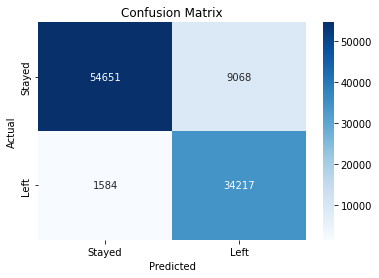

In [4]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(y, savedmodel_predictions)
#plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Stayed', 'Left'], yticklabels=['Stayed', 'Left'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

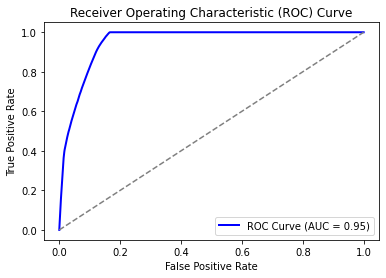

In [5]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y, savedmodel_probabilities)
roc_auc = auc(fpr, tpr)

#plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()